# Collaboration and Competition


### 1. Start the Environment

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
!pip install torchsummary
from torchsummary import summary
from agent import MADDPG

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


### 4. Train the Agent with DDPG

In [7]:
agent = MADDPG(state_size, action_size, num_agents, 0)

In [8]:
summary(agent.actor_local, (24, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           3,200
            Linear-2                  [-1, 128]          16,512
            Linear-3                  [-1, 128]          16,512
            Linear-4                    [-1, 2]             258
Total params: 36,482
Trainable params: 36,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.14
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [9]:
summary(agent.critic_local, [(48, ), (4, )])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           6,272
            Linear-2                  [-1, 128]          17,024
            Linear-3                  [-1, 128]          16,512
            Linear-4                    [-1, 1]             129
Total params: 39,937
Trainable params: 39,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [10]:
def train(n_episodes=2000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    mean_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations  
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            action = agent.act(state)      
            env_info = env.step(action)[brain_name]
            next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if np.any(done):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        mean_score = np.mean(scores_deque)
        mean_scores.append(mean_score)
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, mean_score), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, mean_score))

        if mean_score >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break            
    return scores, mean_scores 

In [11]:
scores, mean_scores = train()

Episode 100	Average Score: 0.0035
Episode 200	Average Score: 0.0085
Episode 300	Average Score: 0.00950
Episode 400	Average Score: 0.0300
Episode 500	Average Score: 0.0355
Episode 600	Average Score: 0.0610
Episode 700	Average Score: 0.2822
Episode 728	Average Score: 0.5083
Environment solved in 728 episodes!	Average Score: 0.51


In [12]:
def plot(scores, mean_scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.plot(np.arange(1, len(mean_scores)+1), mean_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

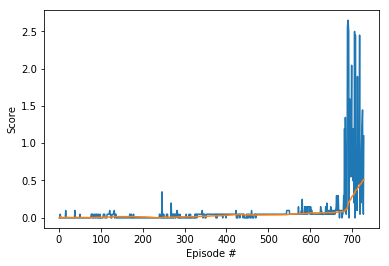

In [13]:
plot(scores, mean_scores)

### 5. Watch a Smart Agent

In [14]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))   
num_episodes = 10
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    state = env_info.vector_observations                   # get the current state (for each agent)
    score = np.zeros(num_agents)  
    while True:            
        action = agent.act(state)      
        env_info = env.step(action)[brain_name]
        next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
        state = next_state
        score += reward        
        if np.any(done):
            break 
    scores.append(np.mean(score))
    print('Total score (averaged over agents) episode {}: {}'.format(i_episode, np.mean(score)))    

Total score (averaged over agents) episode 1: 2.550000037997961
Total score (averaged over agents) episode 2: 0.7950000120326877
Total score (averaged over agents) episode 3: 1.6450000246986747
Total score (averaged over agents) episode 4: 1.5950000239536166
Total score (averaged over agents) episode 5: 2.045000030659139
Total score (averaged over agents) episode 6: 2.550000037997961
Total score (averaged over agents) episode 7: -0.004999999888241291
Total score (averaged over agents) episode 8: 2.550000037997961
Total score (averaged over agents) episode 9: -0.004999999888241291
Total score (averaged over agents) episode 10: 0.04500000085681677


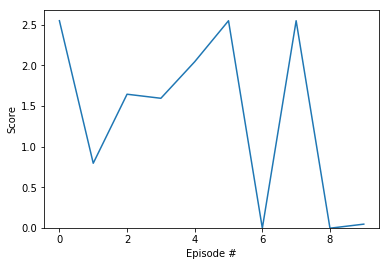

In [15]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.set_ylim(bottom=0)
plt.show()

In [16]:
# env.close()